# **Clinical note generation**

Our project aims to automate the process of writing clinical notes. Clinical notes are a summary of the patient-doctor interaction and are generally written by the doctor after the consultation. They are used for billing, communication between doctors, and as a reminder of the patient's history.


Patient-doctor consultations are recorded as audio, which would be converted into a textual transcript by an out-of-the-box dialogue-based Speech-To-Text model, e.g. [Google Cloud API](https://cloud.google.com/speech-to-text/docs/multiple-voices).


Smaller models such as Meditron-7B [(Huggingface link)](https://huggingface.co/epfl-llm/meditron-7b) probably do not have the capacity to generate a clinical note directly from a dialogue transcript because it involves two separate complex tasks: 

1. **Summarize**: From the dialogue transcript, extract relevant features to create a patient summary, outlining the patient's medical history, current symptoms, and the doctor's diagnosis. 
2. **Generate**: From the patient summary and samples of the clinician's own notes, generate the clinical note.


We therefore break this stage into two language models, each fine-tuned for a specific task.
The combined model then generates the clinical note from the dialogue transcript in 2 steps.

<p align="center">
<img src="figures/pipeline.png" width="70%">
</p>

In [1]:
#!pip install -r requirements.txt

from utils.chat import *
from utils.eval import *    
from utils.infer import *
from utils.data import *
from utils.scorer import *
from utils.generate import *

%reload_ext autoreload
%autoreload 2

SUMMARIES_DIR = os.path.join(DATA_DIR, 'summaries')
SUMMARIZER_DIR = os.path.join(DATA_DIR, 'summarizer')
GENERATOR_DIR = os.path.join(DATA_DIR, 'generator')
DIRECT_DIR = os.path.join(DATA_DIR, 'direct')

/Users/williamzheng/Documents/UmichFolder/2025 Fall Semester /Research 499/LettiNote/myletti/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


WARNING 11-04 10:01:44 _custom_ops.py:19] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
INFO 11-04 10:01:44 importing.py:10] Triton not installed; certain GPU-related functions will not be available.


2024-11-04 10:01:45,434	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



## 1. **Synthetic patient summaries**

For our fine-tuning data, we will use the [NoteChat](https://arxiv.org/abs/2310.15959) dataset [(Huggingface link)](https://huggingface.co/datasets/akemiH/NoteChat). This dataset contains 167K pairs of real clinical notes extracted from [PMC-Patients](https://arxiv.org/abs/2202.13876) with generated patient-doctor conversations.

<p align="center">
<img src="figures/notechat.png" width="50%">
</p>

We extend this dataset of pairs to triplets with GPT-3.5: 

(`clinical note`, `dialogue transcript`) $\to$ (`clinical note`, `dialogue transcript`, `patient summary`)

We extract patient summaries by prompting GPT-3.5 with a clinical note, its corresponding dialogue transcript and a comprehensive template of patient features. 

### 1.1. **Load NoteChat data**

We first take a look at the NoteChat dataset. We load the dataset from the Huggingface library and display a few examples.

In [2]:
notechat_path = 'data/NoteChat.jsonl'

if not os.path.exists(notechat_path):
    notechat = load_dataset("akemiH/NoteChat")['train'].to_pandas()
    notechat.to_json(notechat_path, orient='records', lines=True)
else:
    notechat = pd.read_json(notechat_path, orient='records', lines=True)

notechat.rename(columns={'data': 'note'}, inplace=True)
notechat.head()


Repo card metadata block was not found. Setting CardData to empty.
/Users/williamzheng/Documents/UmichFolder/2025 Fall Semester /Research 499/LettiNote/myletti/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


,note,conversation
0,This 60-year-old male was hospitalized due to ...,"\nDoctor: Hi, Mr. X, I'm Dr. Y. How are you fe..."
1,A 39-year-old man was hospitalized due to an i...,"\nDoctor: Hello, I am Dr. Smith. Can you tell ..."
2,One week after a positive COVID-19 result this...,"\nDoctor: Good morning, how are you feeling to..."
3,This 69-year-old male was admitted to the ICU ...,"Doctor: Good morning, sir. How are you feeling..."
4,This 57-year-old male was admitted to the ICU ...,"\nDoctor: Good morning, Mr. Patient. How are y..."


Here's an example!

In [3]:
note = notechat['note'][0].replace('. ', '.\n')
conversation = notechat['conversation'][0].strip()  

print('CLINICAL NOTE')
print(note)
print('\n\nCONVERSATION')
print(conversation.replace('\n\n', '\n'))

CLINICAL NOTE
This 60-year-old male was hospitalized due to moderate ARDS from COVID-19 with symptoms of fever, dry cough, and dyspnea.
We encountered several difficulties during physical therapy on the acute ward.
First, any change of position or deep breathing triggered coughing attacks that induced oxygen desaturation and dyspnea.
To avoid rapid deterioration and respiratory failure, we instructed and performed position changes very slowly and step-by-step.
In this way, a position change to the 135° prone position () took around 30 minutes.
This approach was well tolerated and increased oxygen saturation, for example, on day 5 with 6 L/min of oxygen from 93% to 97%.
Second, we had to adapt the breathing exercises to avoid prolonged coughing and oxygen desaturation.
Accordingly, we instructed the patient to stop every deep breath before the need to cough and to hold inspiration for better air distribution.
In this manner, the patient performed the breathing exercises well and managed

### 1.2. **Experiment with extraction of patient summaries**


$$\text{Prompt} + \text{Clinical note} + \text{Template (with definitions?)} \to \text{Patient summary}$$

We tested out a few options to see which one works best.

- **Clinical note and/or dialogue transcript?** Dialogue is generated from clinical note, so all information contained in the dialogue should be in the clinical note --> only use clinical note?

- **Zero-shot vs. One-shot?** Do we include an example of (clinical note, dialogue transcript, patient summary) in the prompt? Ideally yes, but it might not fit in the prompt. If we remove the dialogue, it might fit better. 
--> Zero-shot to fit into context. 

- **Template definitions?** Do we include definitions of the template in the prompt? Adding the definitions might not help, and might not fit in the prompt. 

After a few tests, we choose to generate using only clinical notes, zero-shot and using a template with definitions. 

#### **Extraction prompt**

Here's the extraction instruction we pass to GPT-4: 

In [4]:
# Load the extraction prompt
instruction_path = 'generation/instructions/extraction.txt'
with open(instruction_path, 'r') as f:
    instructions = f.read()
print(instructions)

Given the provided clinical note, extract the corresponding patient summary following the template provided. 
Make sure to extract all the information from the clinical note into the template, but do not add any new information. 
If a field is not mentioned, simply write "feature": None.


#### **Template**

We now load the template used to extract patient information. Each field is provided with a definition to help GPT-4 understand the context.

In [5]:
# Load the template
template_path = 'generation/templates/template.json'
with open(template_path, 'r') as f:
    template = json.load(f)

# Load the template definitions
template_def_path = 'generation/templates/template_definitions.json'
with open(template_def_path, 'r') as f:
    template_def = json.load(f)

template_def

{'visit motivation': "Reason for the patient's visit",
 'admission': [{'reason': 'Reason for admission to a care center',
   'date': 'Date of first admission',
   'duration': "Length of patient's stay",
   'care center details': 'Any details of care center the patient was admitted to (e.g. oncology clinic)'}],
 'patient information': {'age': "Patient's age",
  'sex': "Patient's sex",
  'ethnicity': "Patient's ethnicity or nationality",
  'weight': "Patient's weight",
  'height': "Patient's height",
  'family medical history': 'Information about family medical history',
  'recent travels': "Details about patient's recent travels",
  'socio economic context': "Patient's socioeconomic background",
  'occupation': "Patient's occupation"},
 'patient medical history': {'physiological context': 'Relevant physiological history of the patient',
  'psychological context': 'Relevant psychological history of the patient',
  'vaccination history': 'History of vaccinations received by the patient',


### 1.4. **Finally generating patient summaries**

Once we have a good prompting strategy and template, we generate triplets for the whole dataset.

We sort the NoteChat dataset by decreasing order of length of the clinical note. This is because we want to extract patient summaries from the longest clinical notes first, as they are more likely to contain more information.

In [6]:
notechat['length'] = notechat['note'].apply(lambda x: count_tokens(x))
notechat = notechat.sort_values(by=['length'], ascending=False)
display(notechat.head(10))
notechat = notechat.drop(columns=['length'])
notechat['idx'] = notechat.index
notechat.to_json('data/NoteChat_sorted.jsonl', orient='records', lines=True)

,note,conversation,length
15675,The medical history of 44-year old male kidney...,"Doctor: Good morning, can you tell me a little...",529
30182,A 66-year-old male with chronic hypoxemic resp...,"Doctor: Good morning, how are you feeling toda...",524
64786,An outborn male neonate was delivered vaginall...,"\nDoctor: Hello, how are you feeling today?\n\...",522
140140,Patient: 71-year-old male.\nMain symptoms: fev...,"\nDoctor: Good morning, sir. How are you feeli...",521
140324,"P, a 25-year-old male with unknown native kidn...","Doctor: Good morning, sir. How can I help you ...",517
9646,Clinical presentation: A 50-year old female wi...,"\nDoctor: Good morning, how can I help you tod...",514
186647,Clinical presentation: A 50-year old female wi...,"Doctor: Hello, how can I assist you today?\nPa...",514
176647,Clinical presentation: A 50-year old female wi...,"Doctor: Hello, how can I assist you today?\nPa...",514
196647,Clinical presentation: A 50-year old female wi...,"Doctor: Hello, how can I assist you today?\nPa...",514
206647,Clinical presentation: A 50-year old female wi...,"Doctor: Hello, how can I assist you today?\nPa...",514


We're now generating 30K patient summaries from NoteChat clinical notes using our `utils/chat.py` script.

In [13]:
model = 'gpt-4-1106-preview'
chat = chat_gpt_4_turbo

template_path = 'generation/templates/template_definitions.json'
#instruction_path = 'generation/instructions/instructions.txt'
instruction_path = 'generation/instructions/extraction.txt'


data_path = 'data/NoteChat_sorted.jsonl'
save_path = 'generation/saves/summaries_full_gen.jsonl'
keys_path = 'generation/keys.json'

max_tokens = 500000
nb_to_generate = 30000

extract(
    model = model,
    chat = chat,
    template_path=template_path,
    instruction_path=instruction_path,
    data_path=data_path,
    save_path=save_path,
    use_notes=True, 
    use_dialogues=False,
    max_tokens= max_tokens,
    nb_to_generate = nb_to_generate)

Loading Data...
generating summaries...
Loading template...
Loading instructions...
Building prompts...


Building messages: 100%|██████████| 10/10 [00:00<00:00, 371177.35it/s]


Creating sub-batches...


Building sub-batches: 100%|██████████| 10/10 [00:00<00:00, 621.04it/s]

Sub_batch 1/1: 10 calls, 14782 total tokens: 0.14782$


..........

Sub-batch 1 Saved (size 10)


Break for 10 seconds.
End of break.


,idx,data,conversation,summary,note
0,15675,NaN,"Doctor: Good morning, can you tell me a little...","{\n ""visit motivation"": ""Fever, malaise, in...",The medical history of 44-year old male kidney...
1,30182,NaN,"Doctor: Good morning, how are you feeling toda...","{\n ""visit motivation"": ""Single right lung ...",A 66-year-old male with chronic hypoxemic resp...
2,64786,NaN,"\nDoctor: Hello, how are you feeling today?\n\...","{\n ""visit motivation"": ""Severe dyspnea imm...",An outborn male neonate was delivered vaginall...
3,140140,NaN,"\nDoctor: Good morning, sir. How are you feeli...","{\n ""visit motivation"": ""Suspicion of recur...",Patient: 71-year-old male.\nMain symptoms: fev...
4,140324,NaN,"Doctor: Good morning, sir. How can I help you ...","{\n ""visit motivation"": ""Recurrent fever"",\...","P, a 25-year-old male with unknown native kidn..."
5,9646,NaN,"\nDoctor: Good morning, how can I help you tod...","{\n ""visit motivation"": ""Petechiae after 3 ...",Clinical presentation: A 50-year old female wi...
6,186647,NaN,"Doctor: Hello, how can I assist you today?\nPa...","{\n ""visit motivation"": ""Petechiae after 3 ...",Clinical presentation: A 50-year old female wi...
7,176647,NaN,"Doctor: Hello, how can I assist you today?\nPa...","{\n ""visit motivation"": ""Petechiae after 3 ...",Clinical presentation: A 50-year old female wi...
8,196647,NaN,"Doctor: Hello, how can I assist you today?\nPa...","{\n ""visit motivation"": ""Petechiae after 3 ...",Clinical presentation: A 50-year old female wi...
9,206647,NaN,"Doctor: Hello, how can I assist you today?\nPa...","{\n ""visit motivation"": ""Petechiae after 3 ...",Clinical presentation: A 50-year old female wi...


## 2. **Preparing fine-tuning datasets**

We prepare three datasets from 30K triplets of (clinical note, dialogue transcript, patient summary) generated from NoteChat.

- `summarizer_30K.jsonl`: input is the summarizer prompt + synthetic patient-doctor dialog from NoteChat, output is GPT-4's patient summary 

- `generator_30K.jsonl`: input is the generator prompt + patient summary from GPT-4, output is the clinical note from PMC-Patients. 

- `direct_30K.jsonl`: input is the direct prompt + synthetic patient-doctor dialog from NoteChat, output is the clinical note from PMC-Patients.

/Users/williamzheng/Documents/UmichFolder/2025 Fall Semester /Research 499/LettiNote/myletti/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


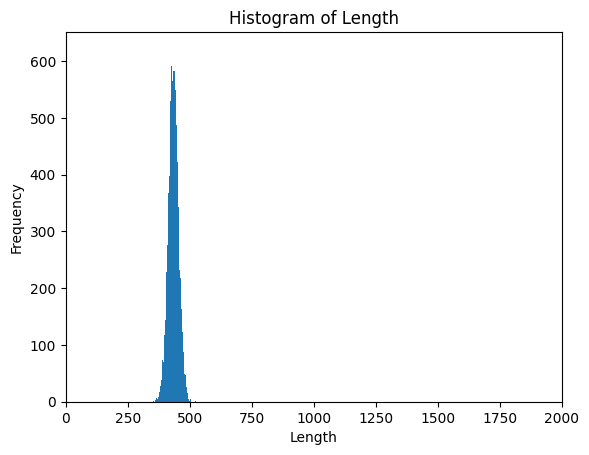

In [21]:
#summaries_path = os.path.join(SUMMARIES_DIR, 'summaries_30K.jsonl')
summaries_path = os.path.join(SUMMARIES_DIR, 'augmented_notes_30k.jsonl') #myadd
summaries = pd.read_json(summaries_path, lines=True)
summaries['summary'] = summaries['summary'].apply(formatting)          
#summaries['data'] = summaries['data'].apply(lambda x: x.strip())
summaries['note'] = summaries['note'].apply(lambda x: x.strip()) #myadd
summaries['conversation'] = summaries['conversation'].apply(lambda x: x.strip().replace('\n\n', '\n'))
summaries.to_json(summaries_path, orient='records', lines=True)

#length_histogram(summaries, key='data')
length_histogram(summaries_path, keys='note')

### 2.1. **Summarizer**: dialog to summary

In [22]:
summarizer_path = os.path.join(SUMMARIZER_DIR, 'summarizer_30K.jsonl')
summarizer = prepare_dataset(data_path=summaries_path, 
                          save_path=summarizer_path,
                          prompt_path='generation/instructions/summarize.txt',
                          prompt_key='conversation',
                          gold_key='summary')
summarizer.head()

,idx,prompt,gold
0,155216,"Given the provided patient-doctor dialog, writ...","{\n""visit motivation"": ""Discomfort in the neck..."
1,77465,"Given the provided patient-doctor dialog, writ...","{\n""visit motivation"": ""Complaints of a dull p..."
2,133948,"Given the provided patient-doctor dialog, writ...","{\n""visit motivation"": ""Pain and restricted ra..."
3,80176,"Given the provided patient-doctor dialog, writ...","{\n""visit motivation"": ""Pain in the left proxi..."
4,72232,"Given the provided patient-doctor dialog, writ...","{\n""visit motivation"": ""Recurrent attacks of p..."


### 2.2. **Generator**: summary to note

In [24]:
generator_path = os.path.join(GENERATOR_DIR, 'generator_30K.jsonl')
generator = prepare_dataset(data_path=summaries_path, 
                         save_path=generator_path,
                         prompt_path='generation/instructions/generate.txt',
                         prompt_key='summary',
                         #gold_key='data')
                         gold_key='note') #myadd
generator.head()

,idx,prompt,gold
0,155216,Given the provided JSON patient information su...,"A a sixteen year-old girl, presented to our Ou..."
1,77465,Given the provided JSON patient information su...,This is the case of a 56-year-old man that was...
2,133948,Given the provided JSON patient information su...,A 36-year old female patient visited our hospi...
3,80176,Given the provided JSON patient information su...,A 49-year-old male presented with a complaint ...
4,72232,Given the provided JSON patient information su...,A 47-year-old male patient was referred to the...


### 2.3. **Direct generation**: dialog to note


In [26]:
direct_path = os.path.join(DIRECT_DIR, 'direct_30K.jsonl')
direct = prepare_dataset(data_path=summaries_path, 
                      save_path=direct_path,
                      prompt_path='generation/instructions/direct.txt',
                      prompt_key='conversation',
                      #gold_key='data')
                      gold_key='note') #myadd
direct.head()

,idx,prompt,gold
0,155216,Given the provided patient-doctor conversation...,"A a sixteen year-old girl, presented to our Ou..."
1,77465,Given the provided patient-doctor conversation...,This is the case of a 56-year-old man that was...
2,133948,Given the provided patient-doctor conversation...,A 36-year old female patient visited our hospi...
3,80176,Given the provided patient-doctor conversation...,A 49-year-old male presented with a complaint ...
4,72232,Given the provided patient-doctor conversation...,A 47-year-old male patient was referred to the...



#### 2.4. **Full clinical notes**

Here, we noticed that the NoteChat dataset contains truncated clinical notes. To fix this issue, we find full 167K clinical notes from the original PMC-Patients dataset and add them to the NoteChat dataset. We find 29798 out of 30000 full clinical notes; the remaining 202 clinical notes are not available in the PMC-Patients dataset and we use the versions from the NoteChat dataset.

**NOTE**: Only the direct dataset has full clinical notes, because we generated patient summaries from NoteChat's truncated notes, and so training a model to either generate to or from a patient summary would encourage the model in forgetting or adding information to the clinical note.

Here, we noticed that the NoteChat dataset contains truncated clinical notes. To fix this issue, we find full 167K clinical notes from the original PMC-Patients dataset and add them to the NoteChat dataset. We find 29798 out of 30000 full clinical notes; the remaining 202 clinical notes are not available in the PMC-Patients dataset and we use the versions from the NoteChat dataset.

| Model | Full clinical notes |
| --- | --- |
| Meditron-7B-summarizer | No |
| Meditron-7B-generator | No |
| Meditron-7B-direct | **Yes** |
| Meditron-13B-summarizer | No |
| Meditron-13B-generator | No |
| Meditron-13B-direct | **Yes** |


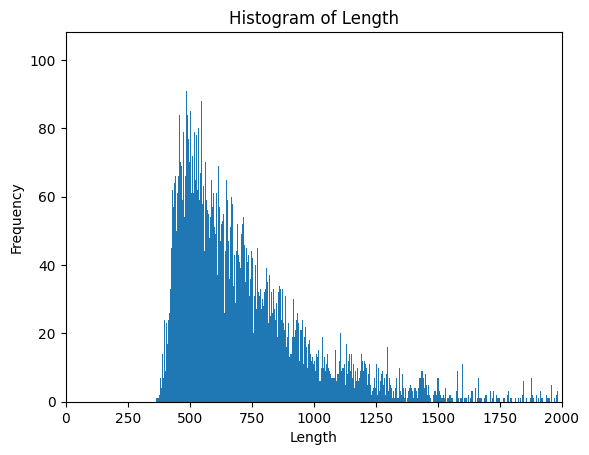

In [30]:
full_summaries_path = os.path.join(SUMMARIES_DIR, 'summaries_full_30K.jsonl')
if os.path.exists(full_summaries_path):
    full_summaries = pd.read_json(full_summaries_path, lines=True)

else: 
    # Load PMC-Patients dataset
    PMC_path = 'data/PMC-Patients.jsonl'
    if os.path.exists(PMC_path): 
        PMC = pd.read_json(PMC_path, orient='records', lines=True)
    else: 
        PMC = load_dataset("zhengyun21/PMC-Patients", split='train').to_pandas()
        PMC.to_json('data/PMC-Patients.jsonl', orient='records', lines=True)

    # Make a set of truncated patient notes from PMC
    full_notes = {}
    truncate = lambda x: x.strip() if len(x) <= 200 else x[:100]
    for i, row in tqdm(PMC.iterrows(), total=len(PMC), desc='Creating set of truncated patient notes'):
        full_notes[truncate(row['patient'])] = i

    # Now iterate through the summaries and find matches in the PMC dataset
    full_summaries = summaries.copy()
    full_summaries['full_note'] = None
    num_matches = 0
    for i, row in tqdm(summaries.iterrows(), total=len(summaries), desc='Matching truncated notes to full notes'):
        #truncated_data = truncate(row['data'])
        truncated_data = truncate(row['note'])
        matches = full_notes.get(truncated_data, None)
        if matches is not None:
            num_matches += 1
            idx = full_notes[truncated_data]
            full_summaries.at[i, 'full_note'] = PMC.iloc[idx]['patient']
        else: 
            #full_summaries.at[i, 'full_note'] = row['data']
            full_summaries.at[i, 'full_note'] = row['note'] #myadd

    print(f'Number of matches: {num_matches} out of {len(summaries)}')
    full_summaries.to_json(full_summaries_path, orient='records', lines=True)
#length_histogram(full_summaries, key='full_note')
length_histogram(full_summaries_path, keys='full_note') #myadd

Now that we have the full notes, we prepare the direct dataset: 

In [31]:
full_summaries_path = os.path.join(SUMMARIES_DIR, 'summaries_full_30K.jsonl')
direct_full_path = os.path.join(DIRECT_DIR, 'direct_full_30K.jsonl')
direct_full = prepare_dataset(data_path=full_summaries_path, 
                           save_path=direct_full_path,
                           prompt_path='generation/instructions/direct.txt',
                           prompt_key='conversation',
                           gold_key='full_note')

Similarly for the summarizer and generator datasets. 

### 2.4. **Train-test split**

We reserve 10% of each dataset to run inference and evaluate the model. We also check for contamination; all is good!

In [32]:
summarizer_train, summarizer_test = split(summarizer_path, test_ratio=0.1)
generator_train, generator_test = split(generator_path, test_ratio=0.1)
direct_train, direct_test = split(direct_path, test_ratio=0.1)
summaries_train, summaries_test = split(full_summaries_path, test_ratio=0.1)

# Double check for contamination
summarizer_train_idx = set(summarizer_train['idx'])
generator_test_idx = set(generator_test['idx'])
direct_test_idx = set(direct_test['idx'])
intersection = summarizer_train_idx.intersection(generator_test_idx)
print(f'Intersection: {len(intersection)}')


Saved train and test sets to data/summarizer/summarizer_30K_train.jsonl and data/summarizer/summarizer_30K_test.jsonl.
Saved train and test sets to data/generator/generator_30K_train.jsonl and data/generator/generator_30K_test.jsonl.
Saved train and test sets to data/direct/direct_30K_train.jsonl and data/direct/direct_30K_test.jsonl.
Saved train and test sets to data/summaries/summaries_full_30K_train.jsonl and data/summaries/summaries_full_30K_test.jsonl.
Intersection: 0


### Some statistics

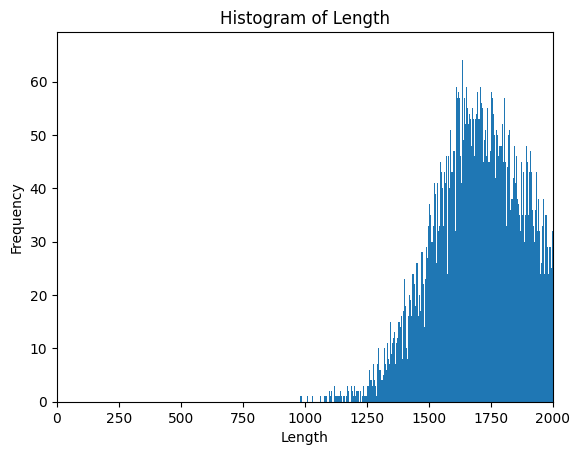

In [33]:
length_histogram(summarizer_path, keys=['prompt', 'gold'])

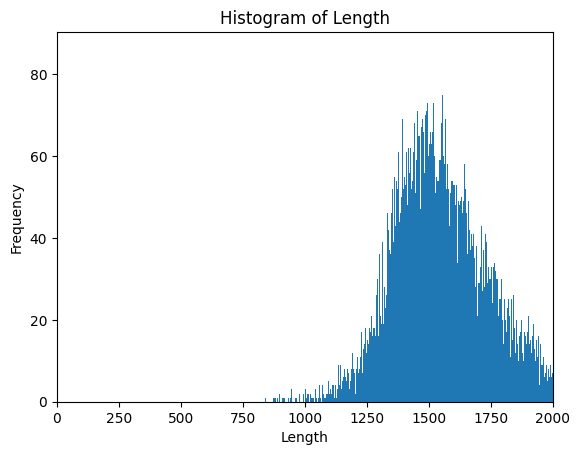

In [34]:
length_histogram(generator_path, keys=['prompt', 'gold'])

In [35]:
prepare(DATA_DIR)

Data preparation initiated.

Loading NoteChat data from data/NoteChat.jsonl...
Sorting NoteChat data by decreasing length...
Generating summaries...
Loading Data...
generating summaries...
Loading template...
Loading instructions...
Building prompts...


Building messages: 100%|██████████| 10/10 [00:00<00:00, 23045.63it/s]


Creating sub-batches...


Building sub-batches: 100%|██████████| 10/10 [00:00<00:00, 440.86it/s]

Sub_batch 1/1: 10 calls, 14652 total tokens: 0.14651999999999998$


..........

Sub-batch 1 Saved (size 10)


Break for 21 seconds.
End of break.
Formatting patient summaries...


KeyError: 'data'

In [ ]:
#NOTE: this function is called in main of infer.py
# but training files? not found


inputPath = "generation/saves/summaries_full_gen.jsonl"
outputPath = "myTesting/testingOut.jsonl" #this file does not exist but needs something
modelName = "gpt3"
mode = "generator-gpt"
max_tokens = 20000

# Generate clinical notes from conversations using an OpenAI model.

infer_openai(
    input_path=inputPath,
    output_path=outputPath,
    model_name=modelName,
    mode=mode,
    max_tokens=max_tokens
)